# Analysis of Survey Data III: Proof Of Concept Analyses

In here I will use the story factors extracted through  [an extensive EFA](step_2_scale_construction_efa.ipynb) to perform a couple of proof of concept analyses. The goal is to demonstrate how the story factors could be used to answer research questions about the influece of various generation settings on the quality and nature of the generated stories. Of course, this idea could be further extended to study the influence of different model architectures, training data, hyperparameters, etc. on the nature of the generated stories.

## Import Packages And Configure Settings


In [1]:
# Base modules
import pandas as pd
import numpy as np
import itertools

# Visualization modules
import matplotlib.pyplot as plt
import seaborn as sns

# Data analysis modules
import pingouin as pg
import scipy.stats as stats
# sklearn
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LinearRegression as linreg
# statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import fdrcorrection

# matplotlib settings
%matplotlib inline
plt.style.use('fivethirtyeight')

import anova_utils


I will be using anova_utils, a package I wrote to contain a few custom utility functions for conducting ANOVAs/AONCVAs. It is available on [GitHub](https://github.com/MWiechmann/anova_utils).

In [2]:
print(anova_utils.__doc__)

ANOVA Utilities (anova_utils)
Custom utility functions for conducting ANOVAs (or ANCOVAs).

Functions:
tukey_outliers: Function to identify outliers using the Tukey method.
qqs_over_groups_and_vars: Function to plot QQ subplots for each variable in a list of variables, over groups in a categorical variable.
check_homoscedacity: Function to check for homoscedacity using heuristics recommended by Blanca et al. (2018).
compare_var_mult_groups: Function to compare the variance of a variable across multiple groups (omnibus test & posthoc). Requires the pingouin package. Adjusting the p-values also requires the statsmodels package.
hist_over_groups: Function to plot histograms for a selection of groups in a categorical variable.
box_over_groups: Function to plot boxplots for a selection of groups in a categorical variable. Requires the seaborn package.



## Read in and prepare the dataset


In [3]:
# Survey response data
aiss = pd.read_csv("data/aiss_factors.csv",
                   index_col=0)
aiss.head(3)

# List of outcome variables (dependent variables)
outcomes = ["coh", "crea_qual", "pace", "avoid_rep", "con_char"]

## Analyze Impact of Preset & Prompt


### First Inspections of Story Factors by Preset & Prompt

In [4]:
print(f"Total sample size: {len(aiss)}")
print(f"\n Sample size per preset:")
display(pd.DataFrame(aiss["preset_label"].value_counts()).transpose())
print(f"\n Sample size per prompt:")
display(pd.DataFrame(aiss["prompt_label"].value_counts()).transpose())

Total sample size: 323

 Sample size per preset:


,Genesis,Ouroboros,Basic Coherence,All-Nighter,Low Rider,Morpho,Ace of Spade,Fandango
preset_label,53,48,43,39,38,38,35,29



 Sample size per prompt:


,Historical Romance,Hard Sci-Fi,Horror,High Fantasy
prompt_label,85,82,80,76


<Figure size 1000x1000 with 0 Axes>

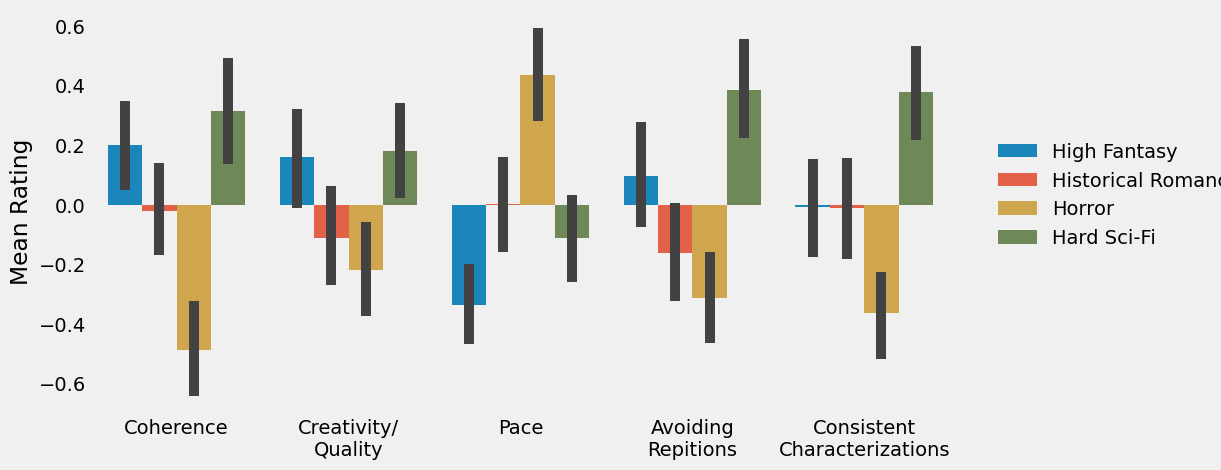

In [5]:
plt.figure(figsize=(10, 10))

tidy = aiss[["response_id", "prompt_label",
             "coh", "crea_qual", "pace", "avoid_rep", "con_char"]
            ].melt(id_vars=['response_id', "prompt_label"])

ax = sns.catplot(data=tidy,
                 kind="bar",
                 y="value", x="variable", hue="prompt_label",
                 errorbar = ("ci", 90), height=5, aspect=2)

ax.set_axis_labels("", "Mean Rating")
ax.set_xticklabels(["Coherence", "Creativity/\nQuality", "Pace", "Avoiding\nRepitions", "Consistent\nCharacterizations"])
plt.grid(False)
ax._legend.set_title(None)
ax._legend.set_bbox_to_anchor([1.0, 0.55])
plt.show()


We can already see that there are clear differences between prompts with different genres. Fantasy and scifi seems to be doing better overall, which is maybe not so surprising given that it probably has a strong focus in the fine-tune data.

The model seemed to have struggled with the horror prompt: Stories were less coherent, lower in creativity/quality, had more repitions and inconsistent characters. I will analyze the precise influence of the prompts in more detail later.

<Figure size 1000x1000 with 0 Axes>

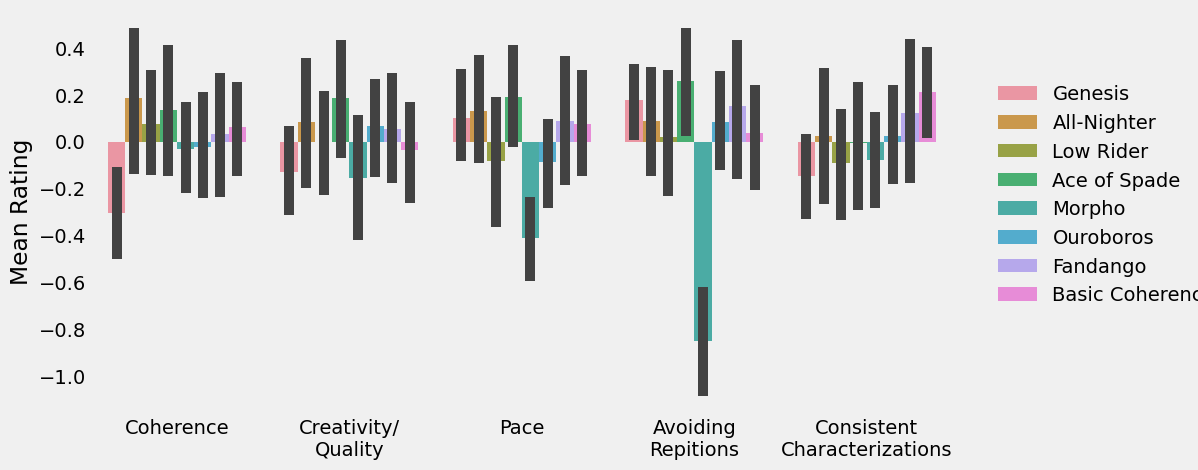

In [6]:
plt.figure(figsize=(10, 10))

tidy = aiss[["response_id", "preset_label",
             "coh", "crea_qual", "pace", "avoid_rep", "con_char"]
            ].melt(id_vars=['response_id', "preset_label"])

ax = sns.catplot(data=tidy,
                 kind="bar",
                 y="value", x="variable", hue="preset_label",
                 errorbar = ("ci", 90), height=5, aspect=2)

ax.set_axis_labels("", "Mean Rating")
ax.set_xticklabels(["Coherence", "Creativity/\nQuality", "Pace", "Avoiding\nRepitions", "Consistent\nCharacterizations"])
plt.grid(False)
ax._legend.set_title(None)
ax._legend.set_bbox_to_anchor([1.0, 0.55])

plt.show()


In general, most of NAI's predefined generation settings (called "presets" in NAI) seem to not differ too much in their story factors. A clear exception however, is the "Morpho" preset, with a lower pace and much more repititions that the other presets.

Furthermore, it looks like the "Genesis" preset might score somewhat lower on Coherence. Given that Genesis is NAI's default preset for this model, this would be a notable finding.

The influence of the presets on the story factors will also be analyzed in more detail later.

### ANCOVA Model Diagnostics


##### Outlier Detection
For outlier detection I will be using Tukey's method (maybe better known as boxplot-method). This method considers data points that are more than 1.5 times the interquartile range (IQR) away from the the 1st or 3rd quartile as mild outliers. Points that are more than 3 times the IQR away from the 1st or 3rd quartile are considered extreme outliers.

I will only check the data for extreme outliers, as some mild outliers are to be expected with this sample size.

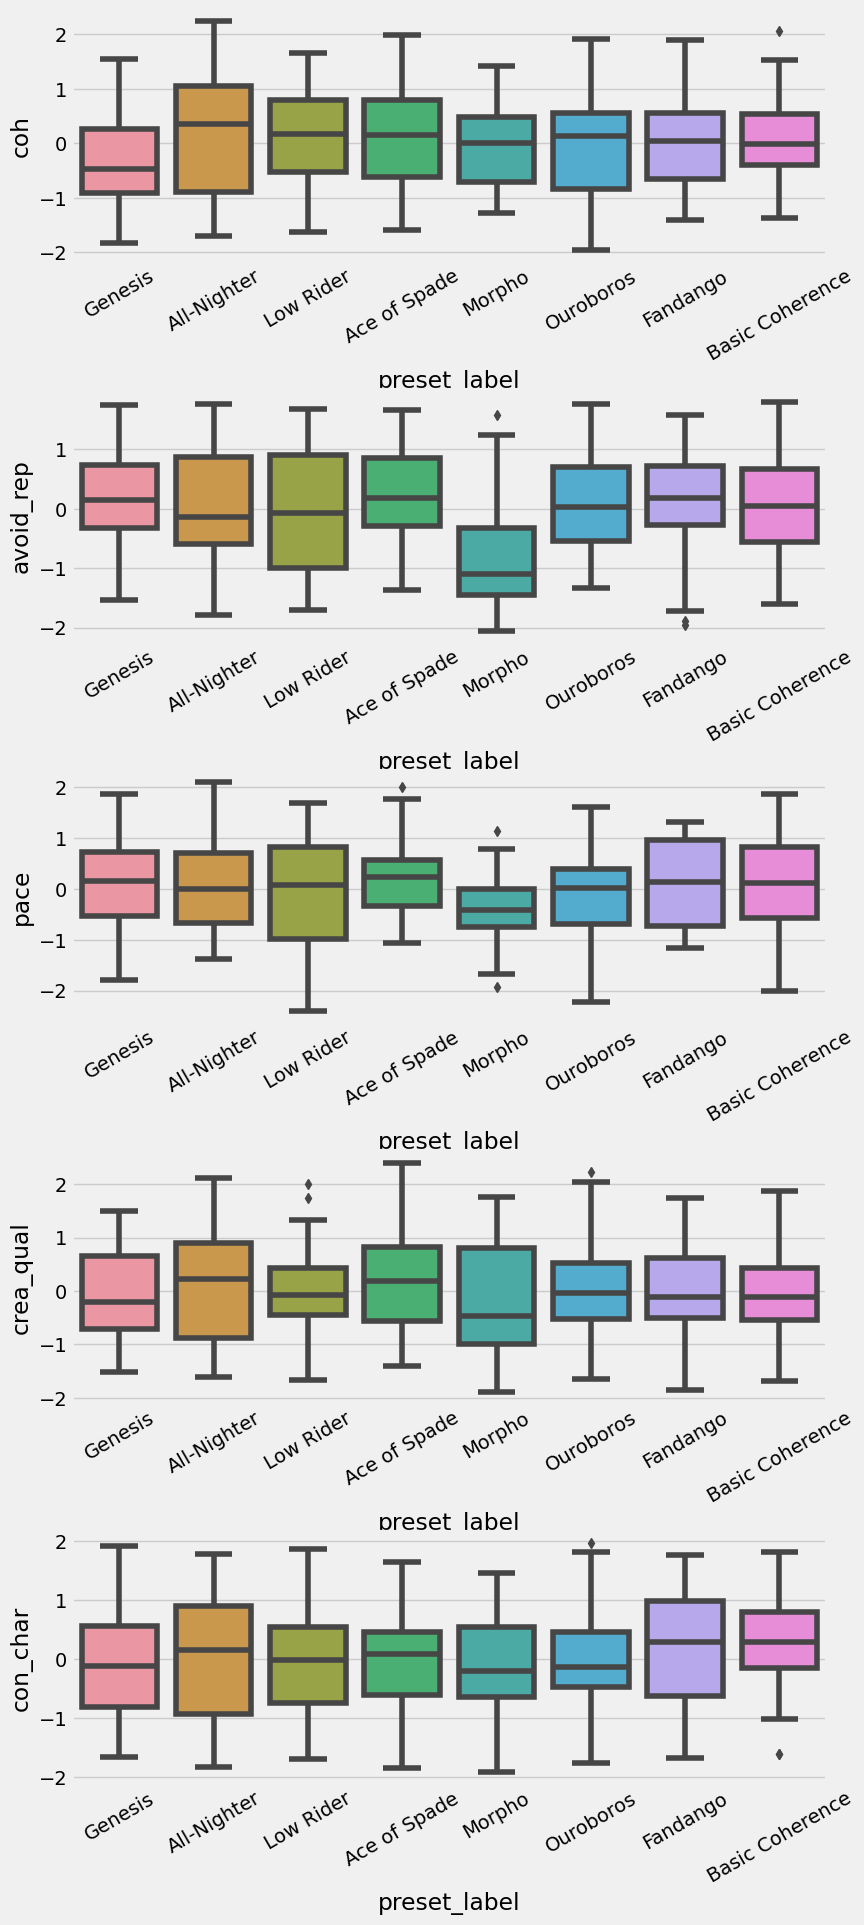

In [7]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)

sns.boxplot(x="preset_label", y="coh", data=aiss, ax=axes[0])
sns.boxplot(x="preset_label", y="avoid_rep", data=aiss, ax=axes[1])
sns.boxplot(x="preset_label", y="pace", data=aiss, ax=axes[2])
sns.boxplot(x="preset_label", y="crea_qual", data=aiss, ax=axes[3])
sns.boxplot(x="preset_label", y="con_char", data=aiss, ax=axes[4])

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


Most data point outside of the "antennas" can already be visually identified as being only being mild outliers.

Just for illustration, I will still double-check Low Rider for creativity/quality and Basic Coherence for consistent characterisation.

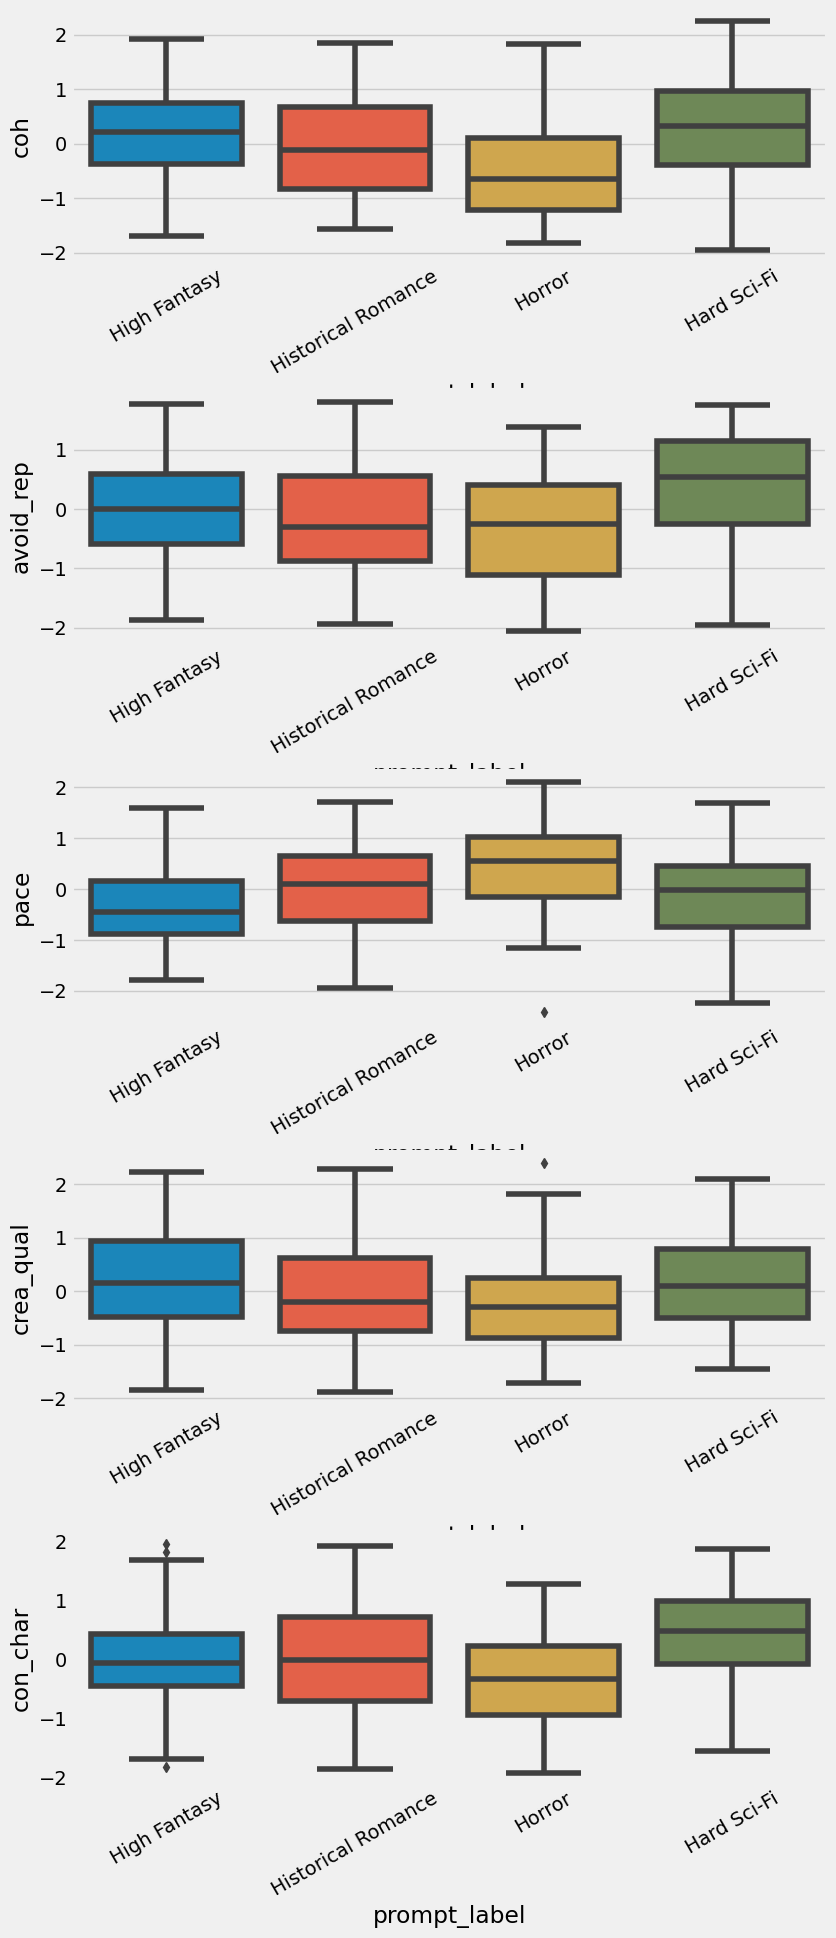

In [8]:
fig, axes = plt.subplots(5, 1, figsize=(10, 20))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.boxplot(x="prompt_label", y="coh", data=aiss, ax=axes[0])
sns.boxplot(x="prompt_label", y="avoid_rep", data=aiss, ax=axes[1])
sns.boxplot(x="prompt_label", y="pace", data=aiss, ax=axes[2])
sns.boxplot(x="prompt_label", y="crea_qual", data=aiss, ax=axes[3])
sns.boxplot(x="prompt_label", y="con_char", data=aiss, ax=axes[4])

for ax in axes:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)


For Horror, there seem to be a couple of mild outliers. Just to be sure, I will double-check them.

In [9]:
# Outliers for Presets

# Outliers creativity
print("\nExterme outliers on crea_qual, Ouroboros preset")
anova_utils.tukey_outliers(aiss[aiss["preset_label"] == "Low Rider"], "crea_qual")

# Outliers consistent characterization
print("\nExterme outliers on pace, Ouroboros")
anova_utils.tukey_outliers(aiss[aiss["preset_label"] ==
                        "Basic Coherence"], "con_char")

# Outliers for Prompts

# Pace
print("\nExterme outliers on tss_avoid rep, Horror prompt")
anova_utils.tukey_outliers(aiss[aiss["prompt_label"] == "Horror"], "avoid_rep")

# Creativity
print("\nExterme outliers on crea_qual, Horror prompt")
anova_utils.tukey_outliers(aiss[aiss["prompt_label"] == "Horror"], "crea_qual")



Exterme outliers on crea_qual, Ouroboros preset
25th Percentile (Q1): -0.44
75th Percentile (Q3): 0.43
IQR: 0.87
Will count cases as outlier with values less than -3.05 or more than 3.04.
With these criteria there are no outlier in the data

Exterme outliers on pace, Ouroboros
25th Percentile (Q1): -0.16
75th Percentile (Q3): 0.80
IQR: 0.95
Will count cases as outlier with values less than -3.02 or more than 3.66.
With these criteria there are no outlier in the data

Exterme outliers on tss_avoid rep, Horror prompt
25th Percentile (Q1): -1.10
75th Percentile (Q3): 0.41
IQR: 1.51
Will count cases as outlier with values less than -5.63 or more than 4.94.
With these criteria there are no outlier in the data

Exterme outliers on crea_qual, Horror prompt
25th Percentile (Q1): -0.87
75th Percentile (Q3): 0.24
IQR: 1.12
Will count cases as outlier with values less than -4.22 or more than 3.59.
With these criteria there are no outlier in the data


No noteworthy outliers present in the data.

#### Normality
I will be checking normality with qqplots.

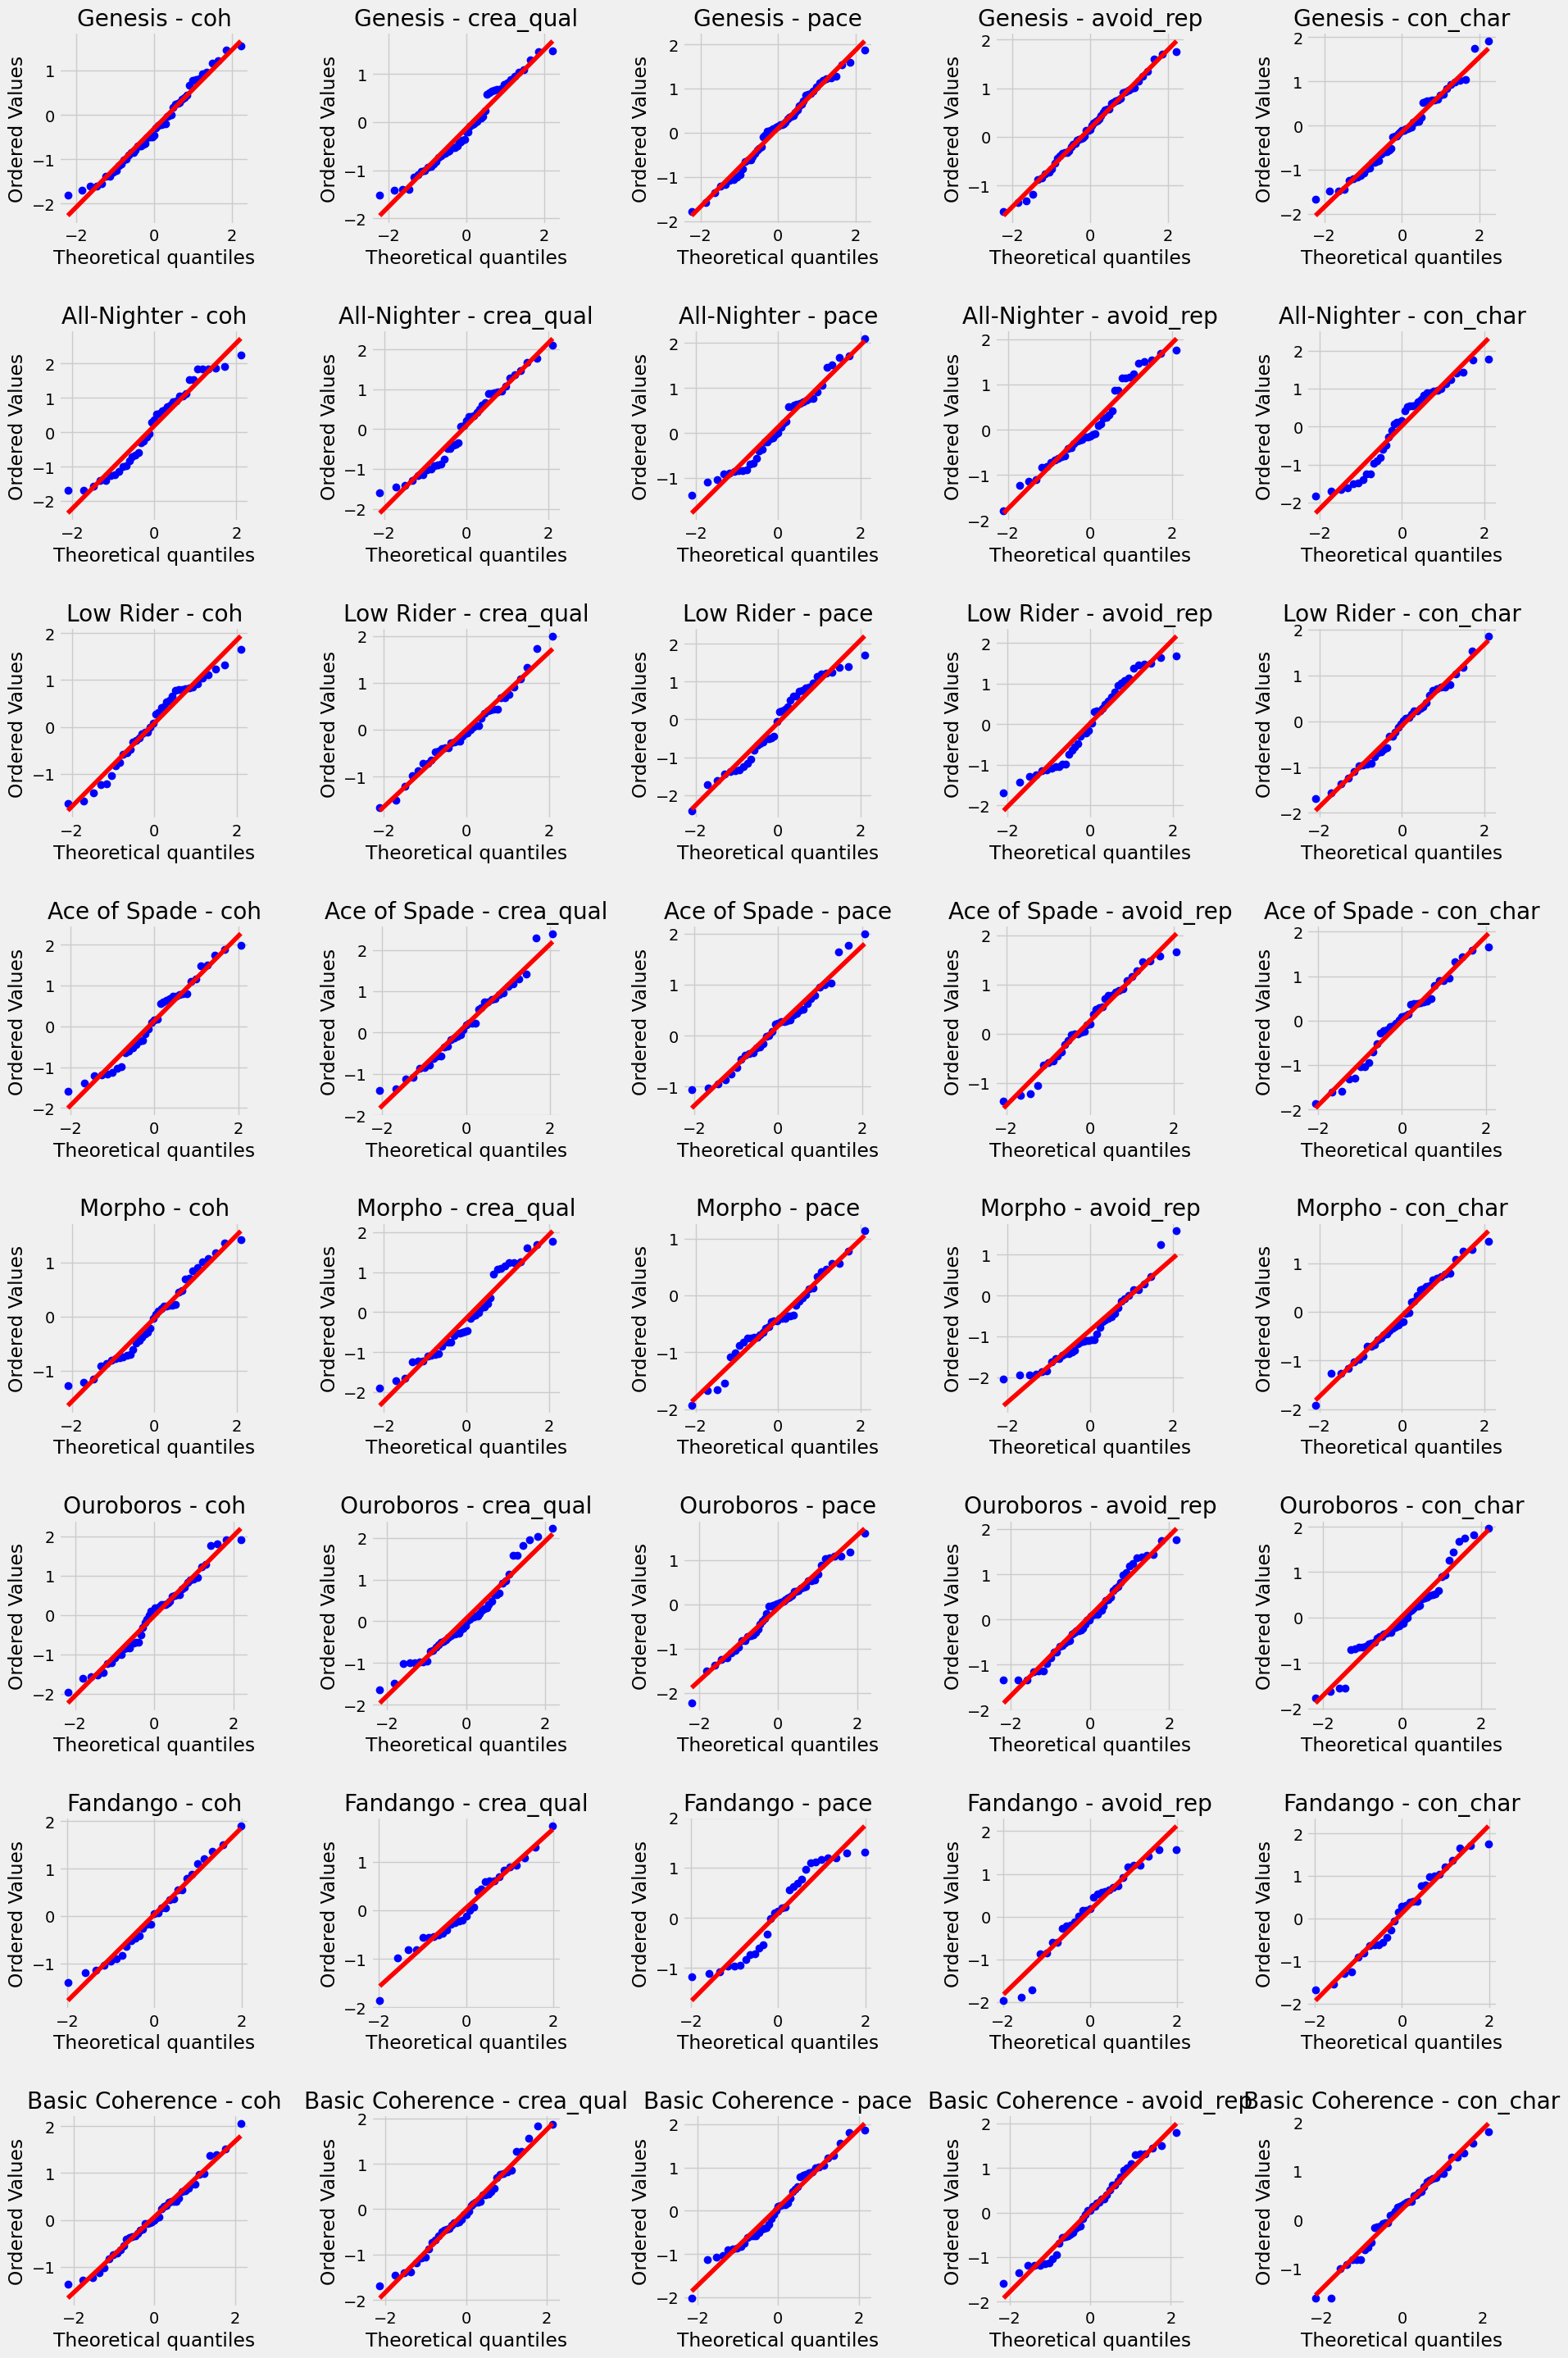

In [10]:
anova_utils.qqs_over_groups_and_vars(aiss, "preset_label", outcomes, size=(20, 30))


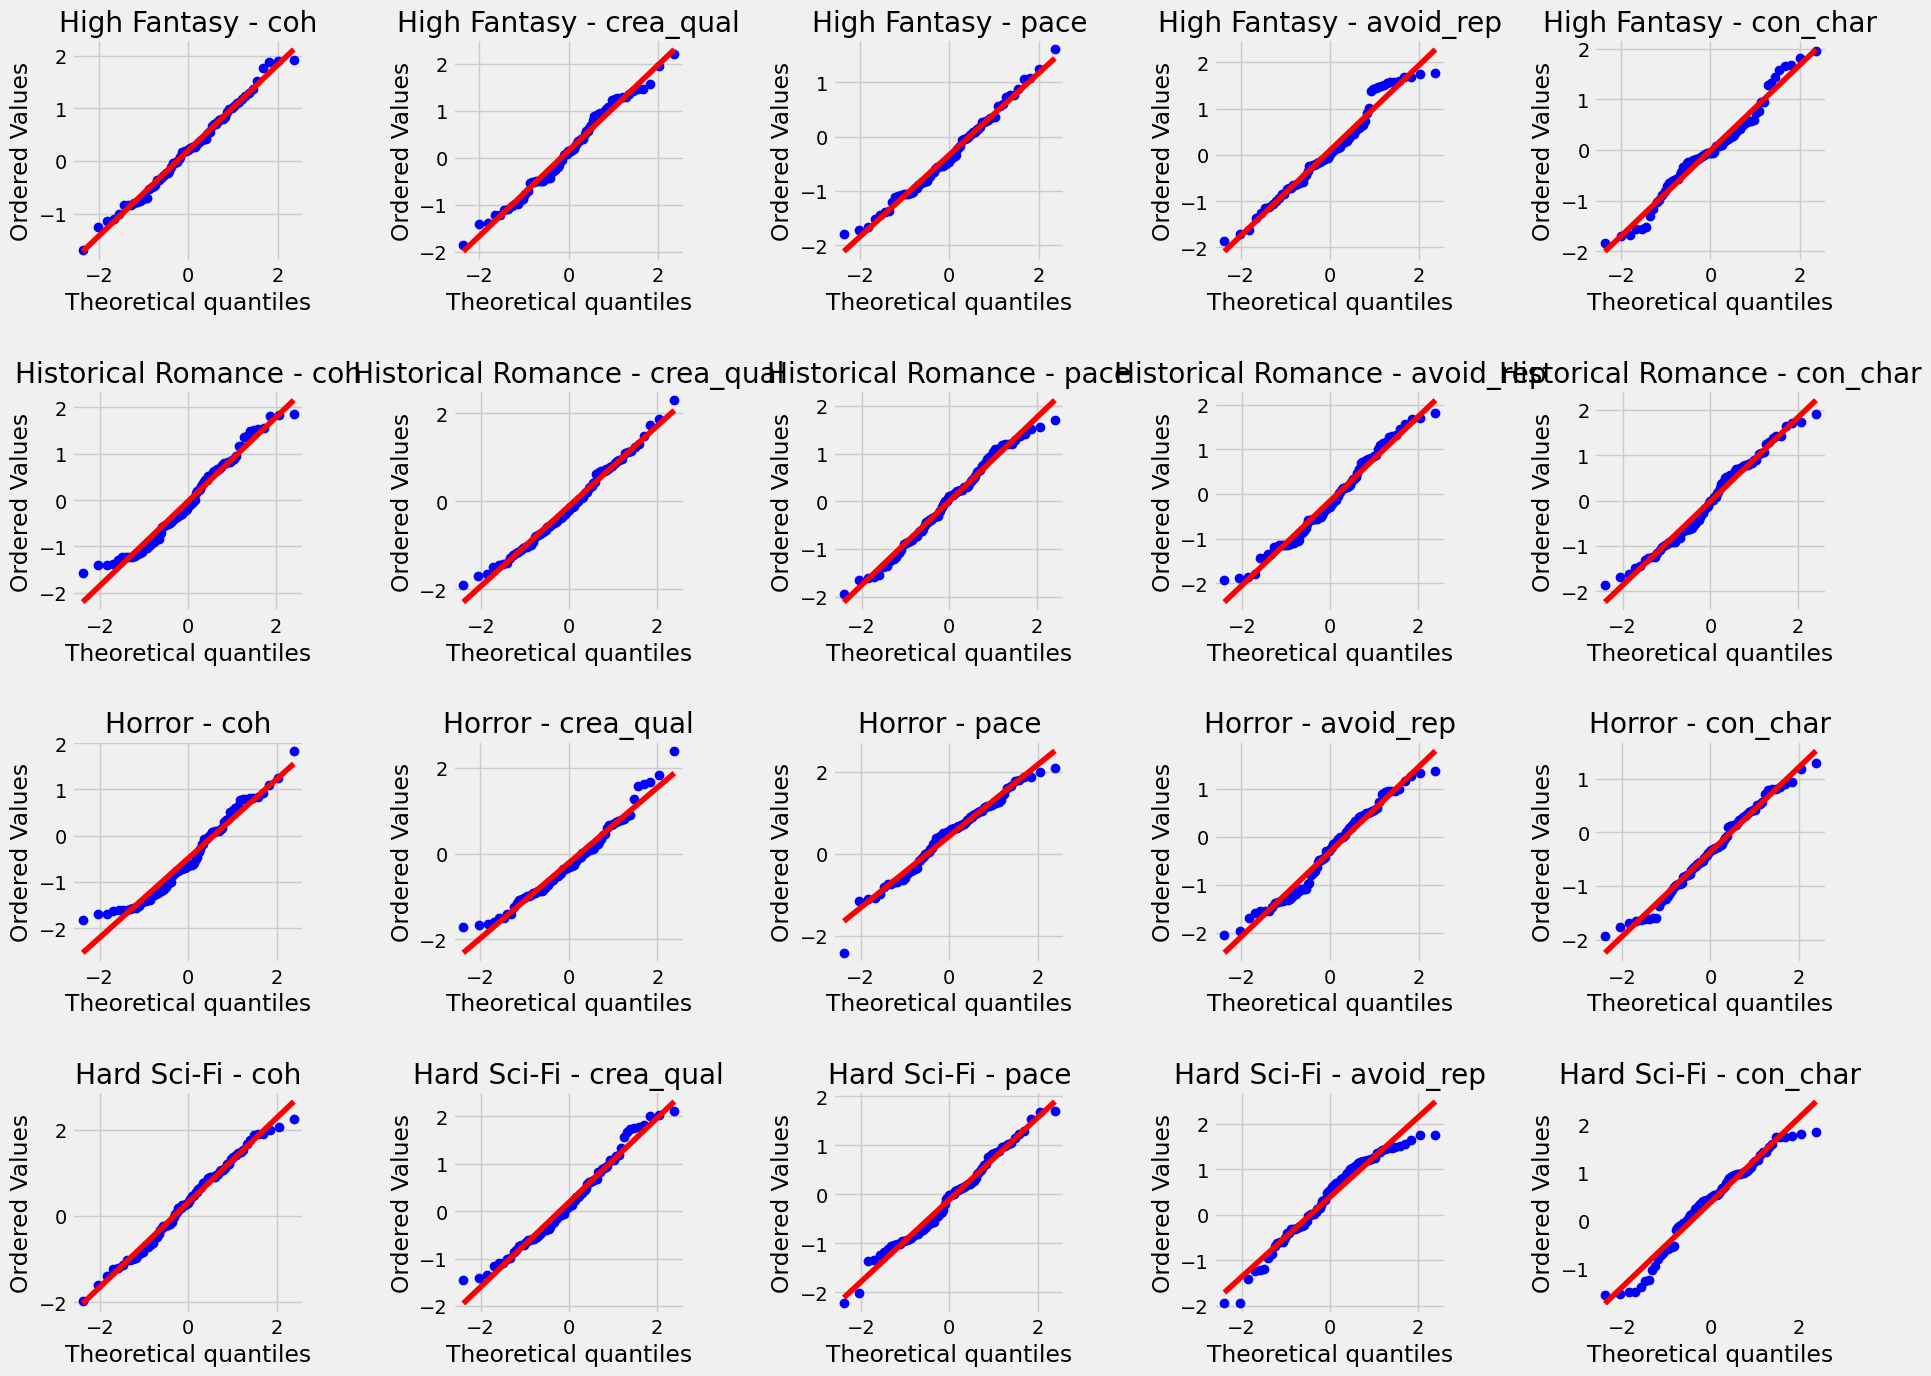

In [11]:
anova_utils.qqs_over_groups_and_vars(aiss, "prompt_label", outcomes, size=(20, 15))


Looks close enough to normal that it should be fine.

#### Homogeneity of Variance
I will be checking homogeneity of variance with heuristics recommended by [Blanca et al., 2018.](https://link.springer.com/article/10.3758/s13428-017-0918-2).

In [12]:
for outcome in outcomes:
    print("Checks for {}".format(outcome))
    print("Preset")
    anova_utils.check_homoscedacity(outcome, "preset_label", aiss)
    print("\nPrompt")
    anova_utils.check_homoscedacity(outcome, "prompt_label", aiss)
    print("\n")


Checks for coh
Preset
Smallest variance for Morpho: 0.57
Largest variance for All-Nighter: 1.43
Variance ratio: 2.50
Variance ratio is > 1.5. Now doing additional checks to see if F-test is robust.
Correlation between sample size and variance (pairing) is -0.06.
Pairing is -0.06, so smaller than 0 and larger than or equal to -.5. The coefficient of sample size variation is 0.32, larger than .16. The variance ratio is 2.50, larger than 2. F-test is too liberal (real alpha might be as high as .1 if variance ratio is 9 or smaller).

Prompt
Smallest variance for High Fantasy: 0.64
Largest variance for Hard Sci-Fi: 0.93
Variance ratio: 1.46
Variance ratio is <= 1.5, F-test will be robust.


Checks for crea_qual
Preset
Smallest variance for Fandango: 0.63
Largest variance for Morpho: 1.07
Variance ratio: 1.69
Variance ratio is > 1.5. Now doing additional checks to see if F-test is robust.
Correlation between sample size and variance (pairing) is -0.10.
Pairing is -0.10, coefficient of sample

Heteroscedasticity is present for a couple of story factors. I will be using HC3 standard errors to account for this.

### Running the ANOVA


Below I will run one ANOVA for each story factor. I will be using the preset, prompt and sample source as the between-subjects factors and the story factor as the dependent variable. For preset and prompt I will be emplyoing contrasts with [sum coding](https://www.statsmodels.org/dev/examples/notebooks/generated/contrasts.html#Sum-(Deviation)-Coding) (also called deviation coding). This means that the mean of each factor level will be compared to the mean of to the mean of the overall sample. For sample source I will be using a simple contrast with [dummy (treatment) coding](https://www.statsmodels.org/dev/examples/notebooks/generated/contrasts.html#Treatment-(Dummy)-Coding). The community sample will be treated as the reference group.

Sum coding will always have one level that is never compared to the grand mean, due to how the contrasts are set up. For statsmodel, this is the last level. To still get the effects for the last category of preset and prompt, I will be running a separate ANOVA with a reverse sum coding, to just grab the results for the last level.

In [13]:
# Create df to store results
# will store coefficients, p-values, and margin of error for 90% confidence interval
results = pd.DataFrame()

# if heteroscedacity, run with fit(cov_type='HC3') and anova_lm(anova_mod, typ=2, robust='HC3')

for outcome in outcomes:
    print(f"\033[1m{outcome}\033[0m")
    ols_formula = outcome + \
        " ~ C(preset_label, Sum) + C(prompt_label, Sum) + C(sample, Treatment(0))"
    ols_formula2 = outcome + \
        " ~ C(preset_label, Sum(0)) + C(prompt_label, Sum(0)) + C(sample, Treatment(0))"
    anova_mod = ols(
        ols_formula, aiss
        ).fit(cov_type='HC3')
    anova_mod2 = ols(
        ols_formula2, aiss
        ).fit(cov_type='HC3')
    print(sm.stats.anova_lm(anova_mod, typ=2, robust='HC3'))
    print(anova_mod.summary(alpha=0.1))

    print(
        f"\nDeviation contrasts for"
        f"\n{anova_mod2.params.index[7]}:"
        f"\tcoef: {anova_mod2.params[7]:.3f}\tp: {anova_mod2.pvalues[7]:.3f}"
        f"\n{anova_mod2.params.index[10]}:"
        f"\tcoef: {anova_mod2.params[10]:.3f}\tp: {anova_mod2.pvalues[10]:.3f}"
        f"\n"
        )

    # Store results
    results[
        outcome + " coeff"
        ] = anova_mod.params
    results[
        outcome + " p-value"
        ] = anova_mod.pvalues
    results[
        outcome + " 90% CI margin"
        ] = anova_mod.conf_int(alpha=0.1)[1] - anova_mod.params

    # Add results from reversed simple contrasts for last categories for prompt and preset
    results.loc[
        anova_mod2.params.index[7], outcome + " coeff"
        ] = anova_mod2.params[7]
    results.loc[
        anova_mod2.params.index[7], outcome + " p-value"
        ] = anova_mod2.pvalues[7]
    results.loc[
        anova_mod2.params.index[7], outcome + " 90% CI margin"
        ] = anova_mod2.conf_int(alpha=0.1)[1][7] - anova_mod2.params[7]

    results.loc[
        anova_mod2.params.index[10], outcome + " coeff"
        ] = anova_mod2.params[10]
    results.loc[
        anova_mod2.params.index[10], outcome + " p-value"
        ] = anova_mod2.pvalues[10]
    results.loc[
        anova_mod2.params.index[10], outcome + " 90% CI margin"
        ] = anova_mod2.conf_int(alpha=0.1)[1][10] - anova_mod2.params[10]


coh
                             sum_sq     df          F        PR(>F)
C(preset_label, Sum)       7.302700    7.0   1.338583  2.314572e-01
C(prompt_label, Sum)      29.640767    3.0  12.677334  7.720309e-08
C(sample, Treatment(0))    0.874292    1.0   1.121802  2.903528e-01
Residual                 242.382148  311.0        NaN           NaN
                            OLS Regression Results                            
Dep. Variable:                    coh   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.105
Method:                 Least Squares   F-statistic:                     4.821
Date:                Mon, 05 Dec 2022   Prob (F-statistic):           7.21e-07
Time:                        22:27:07   Log-Likelihood:                -411.94
No. Observations:                 323   AIC:                             847.9
Df Residuals:                     311   BIC:                             893.2
Df Model:               

The summary above is mising adjustement for multiple comparisons, and perhaps also not the most readable.
So here is one more overview of all coefficients over all ANOVAs, including the p-values, adjusted p-values for multiple comparisons (using the [Benjamini/Hochberg correction for false discovery rate](https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.fdrcorrection.html)), and 90% CI margin of errors. 

In [14]:
# Clean up row names
results.index = results.index.str.replace(
    r'C\(.*[ST]\.(.*)\]', r'\1', regex=True)

# Create lists with all prompt and preset names
presets = list(aiss["preset_label"].unique())
prompts = list(aiss["prompt_label"].unique())

# Fix ordering of rows
order_index = ["Intercept", "Panel"]
order_index.extend(presets)
order_index.extend(prompts)
results = results.reindex(order_index)

# Add adjusted p-values
cols_order = []

for outcome in outcomes:
    # no adjustement for p necessary for sample source
    results.loc[
        "Panel", outcome + " adj_p"
        ] = results.loc["Panel", outcome + " p-value"]
    # adjusted ps for presets
    results.loc[
        presets, outcome + " adj_p"
        ] = fdrcorrection(
        results.loc[presets, outcome + " p-value"],
        alpha=0.1
            )[1]
    # adjusted ps for prompts
    results.loc[
        prompts, outcome + " adj_p"
        ] = fdrcorrection(
        results.loc[prompts, outcome + " p-value"],
        alpha=0.1
        )[1]

    cols_order.extend([
        outcome + " coeff",
        outcome + " p-value",
        outcome + " adj_p",
        outcome + " 90% CI margin"
        ])

results = results[cols_order]

results.round(4)

,coh coeff,coh p-value,coh adj_p,coh 90% CI margin,crea_qual coeff,crea_qual p-value,crea_qual adj_p,crea_qual 90% CI margin,pace coeff,pace p-value,pace adj_p,pace 90% CI margin,avoid_rep coeff,avoid_rep p-value,avoid_rep adj_p,avoid_rep 90% CI margin,con_char coeff,con_char p-value,con_char adj_p,con_char 90% CI margin
Intercept,0.0678,0.3675,NaN,0.1237,-0.1246,0.0659,NaN,0.1115,0.1272,0.0564,NaN,0.1096,0.2068,0.0065,NaN,0.1249,-0.0259,0.7394,NaN,0.1279
Panel,-0.1043,0.2895,0.2895,0.1620,0.2693,0.0075,0.0075,0.1656,-0.2580,0.0054,0.0054,0.1525,-0.4251,0.0000,0.0000,0.1568,0.0535,0.5848,0.5848,0.1611
Genesis,-0.3081,0.0058,0.0462,0.1836,-0.1325,0.2252,0.7720,0.1798,0.1020,0.3271,0.5524,0.1712,0.1967,0.0553,0.1474,0.1688,-0.1203,0.2921,0.9173,0.1877
All-Nighter,0.1029,0.5422,0.8211,0.2777,0.0533,0.7038,0.9914,0.2306,0.1577,0.2404,0.5524,0.2209,0.0035,0.9778,0.9778,0.2088,-0.0433,0.7810,0.9173,0.2563
Low Rider,0.0865,0.5292,0.8211,0.2261,0.0014,0.9914,0.9914,0.2103,-0.1066,0.5046,0.5767,0.2627,0.0395,0.7621,0.8710,0.2145,-0.0742,0.5593,0.9173,0.2090
Ace of Spade,0.1662,0.2397,0.8211,0.2325,0.1974,0.1839,0.7720,0.2443,0.1575,0.1465,0.5524,0.1785,0.3181,0.0183,0.0733,0.2218,0.0148,0.9173,0.9173,0.2343
Morpho,-0.0455,0.6969,0.8211,0.1922,-0.1587,0.2895,0.7720,0.2464,-0.4028,0.0003,0.0023,0.1828,-0.8314,0.0000,0.0000,0.2127,-0.0687,0.5724,0.9173,0.2001
Ouroboros,-0.0314,0.8011,0.8211,0.2050,0.0466,0.7002,0.9914,0.1991,-0.0833,0.4679,0.5767,0.1888,0.0952,0.4008,0.7320,0.1864,0.0263,0.8197,0.9173,0.1895
Fandango,-0.0370,0.8211,0.8211,0.2689,0.0041,0.9785,0.9914,0.2530,0.1325,0.3453,0.5524,0.2309,0.1233,0.4575,0.7320,0.2730,0.0420,0.8045,0.9173,0.2789
Basic Coherence,0.0664,0.5726,0.8211,0.1935,-0.0116,0.9297,0.9914,0.2166,0.0430,0.7004,0.7004,0.1840,0.0550,0.6559,0.8710,0.2031,0.2235,0.0542,0.4334,0.1909


To get a quick overview of noteworthy effects, I will be filtering the results for (adjusted) p-values below 0.1.

Note that I am using an alpha-level of 0.1 here, which is a bit more lenient than the conventinoal 0.05. This is because this analysis was used to give some tentative recommendations for the NAI user community. This situation is fairly low-stakes, and I considered alpha = .05 to be overkill for this purpose.

In [15]:
adj_p_cols = results.columns.str.extractall("(.*adj_p)").values.flatten()
mask_sig = (results[adj_p_cols] < 0.1).any(axis=1)

# Show results, highlighting significant results
results[mask_sig].round(4).style.applymap(lambda x: "background-color: yellow" if x < 0.1 else "", subset=adj_p_cols)

,coh coeff,coh p-value,coh adj_p,coh 90% CI margin,crea_qual coeff,crea_qual p-value,crea_qual adj_p,crea_qual 90% CI margin,pace coeff,pace p-value,pace adj_p,pace 90% CI margin,avoid_rep coeff,avoid_rep p-value,avoid_rep adj_p,avoid_rep 90% CI margin,con_char coeff,con_char p-value,con_char adj_p,con_char 90% CI margin
Panel,-0.104300,0.289500,0.289500,0.162000,0.269300,0.007500,0.007500,0.165600,-0.258000,0.005400,0.005400,0.152500,-0.425100,0.000000,0.000000,0.156800,0.053500,0.584800,0.584800,0.161100
Genesis,-0.308100,0.005800,0.046200,0.183600,-0.132500,0.225200,0.772000,0.179800,0.102000,0.327100,0.552400,0.171200,0.196700,0.055300,0.147400,0.168800,-0.120300,0.292100,0.917300,0.187700
Ace of Spade,0.166200,0.239700,0.821100,0.232500,0.197400,0.183900,0.772000,0.244300,0.157500,0.146500,0.552400,0.178500,0.318100,0.018300,0.073300,0.221800,0.014800,0.917300,0.917300,0.234300
Morpho,-0.045500,0.696900,0.821100,0.192200,-0.158700,0.289500,0.772000,0.246400,-0.402800,0.000300,0.002300,0.182800,-0.831400,0.000000,0.000000,0.212700,-0.068700,0.572400,0.917300,0.200100
High Fantasy,0.219200,0.009000,0.012000,0.138000,0.174500,0.048900,0.065200,0.145700,-0.324900,0.000000,0.000100,0.126900,0.104700,0.221700,0.221700,0.140900,0.007000,0.934700,0.934700,0.139800
Historical Romance,-0.027700,0.754500,0.754500,0.145900,-0.122500,0.152200,0.152200,0.140700,0.008700,0.913500,0.913500,0.131700,-0.149900,0.069500,0.092700,0.135800,-0.020600,0.814800,0.934700,0.144700
Horror,-0.482600,0.000000,0.000000,0.139600,-0.236800,0.005500,0.022200,0.140400,0.457200,0.000000,0.000000,0.131900,-0.304400,0.000200,0.000300,0.132400,-0.365200,0.000000,0.000000,0.128900
Hard Sci-Fi,0.291100,0.001100,0.002200,0.146600,0.184800,0.035800,0.065200,0.144800,-0.141000,0.095100,0.126800,0.139000,0.349600,0.000000,0.000100,0.132800,0.378900,0.000000,0.000000,0.144200


### Summary of Mean Differences Between Presets
#### Community Sample ("AI Users") vs. Panel Sample (mostly students)
* Panel users rated story creativity/quality higher than AI users.
* Panel users rated avoiding repetitions and pace lower than AI users.
#### Presets
* The "Genesis" preset scored lower on story coherence than the other presets.
* The "Ace of Spades" preset performed better on avoiding repetitions than the other presets.
* The "Morpho" received lower ratings on pace and avoiding repetitions than the other presets.
#### Prompts
* High Fantasy stories scored higher on coherence and creativity/quality than stories generated with the other prompts. It scored lower on pace, however.
* The historical romance prompt produced stories with lower ratings on avoiding repetitions than the other prompts.
* The model had clear trouble with the horror prompt, scoring lower on coherence, creativity/quality, avoiding repetitions and consistent characterisation. However, pace was rated higher than for the other prompts.

## Visualizing the Results


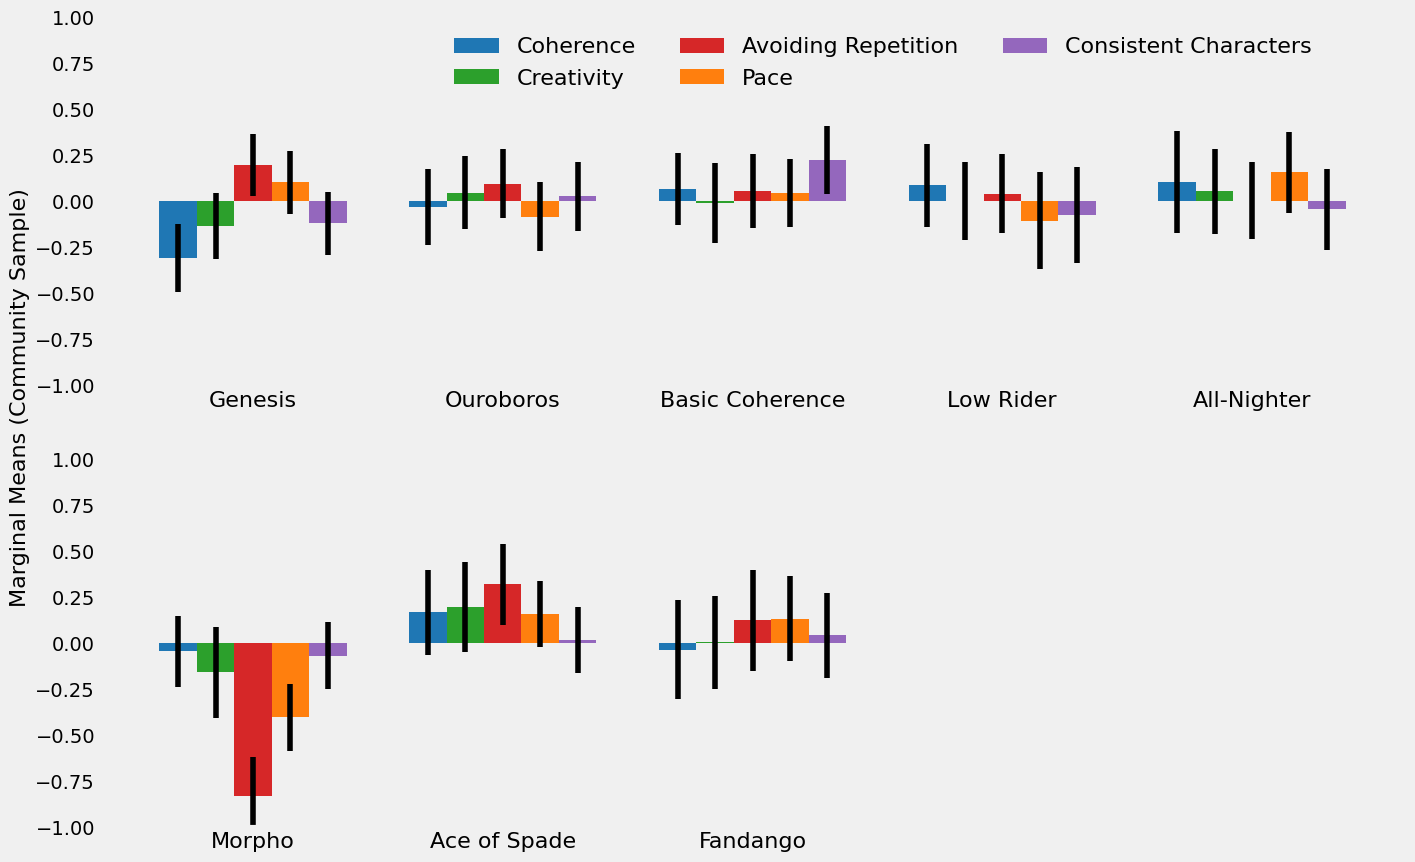

In [16]:
labels = [
    "Coherence", "Creativity",
    "Avoiding Repitition", "Pace", "Consistent Characters"
    ]
presets_1 = [
    "Genesis", "Ouroboros",
    "Basic Coherence", "Low Rider", "All-Nighter"
    ]
presets_2 = ["Morpho", "Ace of Spade", "Fandango"]

preset_to_graph = [presets_1, presets_2]

max_n_presets = max([len(x) for x in preset_to_graph])

fig, axes = plt.subplots(2, 1, figsize=(15, 10))
# fig.tight_layout(pad=5.0)
plt.setp(axes, ylim=(-1, 1))
fig.text(
    0.02, 0.5,
    "Marginal Means (Community Sample)",
    va='center',
    rotation='vertical', fontsize=16
    )

i = 0
for pre_li in preset_to_graph:

    # create dicts with a key for each outcome with an empty list as value for each
    # values are centered around the mean for the community sample (!)
    # so a value of 0 is exactly the expected mean for the community sample
    marginal_means_dict = {outcome: [] for outcome in outcomes}
    yerr_dict = {outcome: [] for outcome in outcomes}

    prod_presets_outcomes = itertools.product(pre_li, outcomes)

    for preset, outcome in prod_presets_outcomes:
        marginal_means_dict[outcome].append(
            results.loc[preset, outcome + " coeff"]
            )
        yerr_dict[outcome].append(
            results.loc[preset, outcome + " 90% CI margin"]
            )

    # Compute difference in length to longest row
    diff_len = max_n_presets - len(pre_li)

    # fill up dictonaries with 0 if less values than the longest row
    if diff_len > 0:
        for outcome in outcomes:
            marginal_means_dict[outcome].extend([0]*diff_len)
            yerr_dict[outcome].extend([0]*diff_len)

    x = np.arange(len(marginal_means_dict["crea_qual"]))  # label locations
    width = 0.15  # width of bars

    cur_ax = axes[i]
    n_presets = len(pre_li)

    x_labels = pre_li
    x_labels.extend([""]*diff_len)

    cur_ax.set_xticks(x)
    cur_ax.set_xticklabels(x_labels, fontsize=16)

    cur_ax.bar(
        x-0.3,marginal_means_dict["coh"], width,
        yerr=yerr_dict["coh"], label="Coherence", color="tab:blue"
        )

    cur_ax.bar(
        x-0.15, marginal_means_dict["crea_qual"], width,
        yerr=yerr_dict["crea_qual"], label="Creativity", color="tab:green"
        )

    cur_ax.bar(
        x, marginal_means_dict["avoid_rep"], width,
        yerr=yerr_dict["avoid_rep"], label="Avoiding Repetition", color="tab:red"
        )

    cur_ax.bar(
        x+0.15, marginal_means_dict["pace"], width,
        yerr=yerr_dict["pace"], label="Pace", color="tab:orange"
        )

    cur_ax.bar(
        x+0.3, marginal_means_dict["con_char"], width,
        yerr=yerr_dict["pace"], label="Consistent Characters", color="tab:purple"
        )

    cur_ax.grid(False)

    i += 1

axes[0].legend(
    frameon=False, fontsize=16, loc='upper center',
    ncol=3, bbox_to_anchor=(0.6, 1)
    )

# fig.tight_layout()
plt.show()

fig.savefig('graphs/gen_presets_preview.png', bbox_inches="tight")


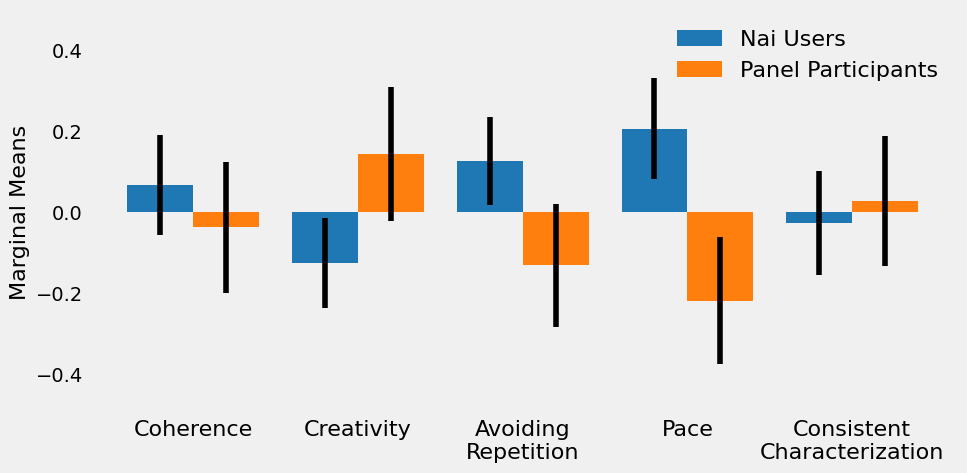

In [17]:
# Graph for Community vs Panel

# create dicts with a key for pe sample source with an empty list as value for each
marginal_means_dict = {"Community": [], "Panel": []}
yerr_dict = {"Community": [], "Panel": []}

outcome_labels = [
    "Coherence", "Creativity",
    "Avoiding\nRepetition", "Pace", "Consistent\nCharacterization"
    ]

for outcome in outcomes:
    marginal_means_dict["Community"].append(
        results.loc["Intercept", outcome + " coeff"]
        )
    yerr_dict["Community"].append(
        results.loc["Intercept", outcome + " 90% CI margin"]
        )

    marginal_means_dict["Panel"].append(
        results.loc["Intercept", outcome + " coeff"]
        + results.loc["Panel", outcome + " coeff"]
        )
    yerr_dict["Panel"].append(
        results.loc["Panel", outcome + " 90% CI margin"]
        )

figure = plt.figure(figsize=(10, 5))

x = np.arange(len(marginal_means_dict["Community"]))  # label locations
width = 0.4  # width of bars

plt.bar(
    x-0.2, marginal_means_dict["Community"], width,
    yerr=yerr_dict["Community"], label="Nai Users", color="tab:blue"
    )
plt.bar(
    x+0.2, marginal_means_dict["Panel"], width,
    yerr=yerr_dict["Panel"], label="Panel Participants", color="tab:orange"
    )

plt.ylim(-0.5, 0.5)
plt.ylabel("Marginal Means", fontsize=16)
plt.xticks(x, outcome_labels, fontsize=16)

plt.legend(frameon=False, fontsize=16, loc='upper right')
plt.grid(False)
#plt.title("Genesis & Low Rider")
# figure.tight_layout()
plt.show()

figure.savefig('graphs/community_vs_panel.png', bbox_inches="tight")


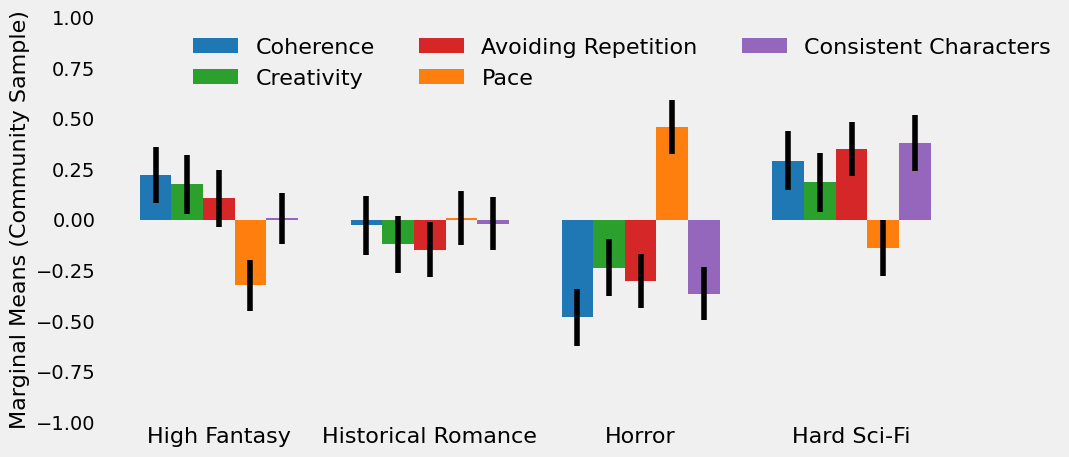

In [18]:
# Create graph for prompts

# create dicts with a key for each outcome with an empty list as value for each
marginal_means_dict = {outcome: [] for outcome in outcomes}
yerr_dict = {outcome: [] for outcome in outcomes}

for prompt, outcome in itertools.product(prompts, outcomes):
    marginal_means_dict[outcome].append(
        results.loc[prompt, outcome + " coeff"]
        )
    yerr_dict[outcome].append(
        results.loc[prompt, outcome + " 90% CI margin"]
        )

figure = plt.figure(figsize=(10, 5))

x = np.arange(len(marginal_means_dict["crea_qual"]))  # label locations
width = 0.15  # width of bars

plt.bar(
        x-0.3, marginal_means_dict["coh"], width,
        yerr=yerr_dict["coh"], label="Coherence", color="tab:blue"
        )

plt.bar(
        x-0.15, marginal_means_dict["crea_qual"], width,
        yerr=yerr_dict["crea_qual"], label="Creativity", color="tab:green"
        )

plt.bar(
        x, marginal_means_dict["avoid_rep"], width,
        yerr=yerr_dict["avoid_rep"], label="Avoiding Repetition", color="tab:red"
        )

plt.bar(
        x+0.15, marginal_means_dict["pace"], width,
        yerr=yerr_dict["pace"], label="Pace", color="tab:orange"
        )

plt.bar(
        x+0.3, marginal_means_dict["con_char"], width,
        yerr=yerr_dict["pace"], label="Consistent Characters", color="tab:purple"
        )

plt.ylim(-1, 1)
plt.ylabel("Marginal Means (Community Sample)", fontsize=16)
plt.xticks(x, prompts, fontsize=16)

plt.legend(frameon=False, fontsize=16, loc='upper center',
           ncol=3, bbox_to_anchor=(0.6, 1))
# plt.legend(frameon=False, bbox_to_anchor = (1,.9), fontsize = 16)
plt.grid(False)
# figure.tight_layout()
plt.show()

figure.savefig('graphs/gen_prompts.png', bbox_inches="tight")


# Analyze Consistency of Story Aspects Across Presets & Prompts
The presets analyzed above apply a variety of different generation settings like [temperature](https://medium.com/@imisri1/how-to-set-sampling-temperature-for-gpt-models-762887df1fac), samling ([top-k](https://huggingface.co/blog/how-to-generate#top-k-sampling), [top-p](https://huggingface.co/blog/how-to-generate#top-p-nucleus-sampling), [tfs](https://www.trentonbricken.com/Tail-Free-Sampling/), etc), and repetition penalty. Together, these settings might do two things:
* Cut out bad tokens – this should increase the average scores on story aspects. These average scores over several outputs were analyzed in the ANOVAs above.
* Change the distribution of token probabilities. This can either make likely tokens even more likely, leading to fairly consistent outputs. Or it can make likely tokens less prominent and strengthen somewhat unlikely tokens. This would make outputs more varied. In other words, presets might differ in their variance of story aspect scores. Two presets might differ in how consistent their outputs are, even if they have the same average.

To analyze the latter point, I will be employing Levene's test for homogeneity of variance. This test will tell me whether the variance of the story aspect scores is the same across presets and prompts.

In [19]:
print("\033[1mPRESETS\033[0m")
for outcome in outcomes:
    print(("_"*75) + "\n")
    print(f"\033[1m{outcome}\033[0m")
    anova_utils.compare_var_mult_groups(aiss, outcome, "preset_label", alpha = 0.1, return_results=False)

PRESETS
___________________________________________________________________________

coh
Omnibus test:
             W    pval  equal_var
levene  2.6289  0.0119      False

Variances are not equal, doing posthoc tests:
Average SD: 0.9331

Presets with adjusted p-vals < 0.10 displayed below:

All-Nighter:
              W   pval  equal_var      sd  adj_p
levene  11.0401  0.001      False  1.1941  0.008
___________________________________________________________________________

crea_qual
Omnibus test:
             W    pval  equal_var
levene  1.1229  0.3483       True

___________________________________________________________________________

pace
Omnibus test:
            W    pval  equal_var
levene  2.692  0.0101      False

Variances are not equal, doing posthoc tests:
Average SD: 0.8719

Presets with adjusted p-vals < 0.10 displayed below:

Low Rider:
             W    pval  equal_var      sd   adj_p
levene  8.8177  0.0032      False  1.0773  0.0257

Morpho:
             W    pval  

In [20]:
print("\033[1mPROMPTS\033[0m")
for outcome in outcomes:
    print(("_"*75) + "\n")
    print(f"\033[1m{outcome}\033[0m")
    anova_utils.compare_var_mult_groups(aiss, outcome, "prompt_label", alpha = 0.1, return_results=False)

PROMPTS
___________________________________________________________________________

coh
Omnibus test:
             W    pval  equal_var
levene  1.4621  0.2248       True

___________________________________________________________________________

crea_qual
Omnibus test:
             W    pval  equal_var
levene  0.1983  0.8975       True

___________________________________________________________________________

pace
Omnibus test:
             W    pval  equal_var
levene  0.6722  0.5696       True

___________________________________________________________________________

avoid_rep
Omnibus test:
             W    pval  equal_var
levene  0.1151  0.9512       True

___________________________________________________________________________

con_char
Omnibus test:
             W    pval  equal_var
levene  1.6991  0.1671       True



* Stories generated with the All-Nighter preset showed higher variance in coherence than stories generated with the other presets.
* Regarding pace, Low Rider showed higher variance, while Morpho showed lower variance than the other presets.

## Visualize Findings On Consistency


### Coherence: High Variance for All-Nighter

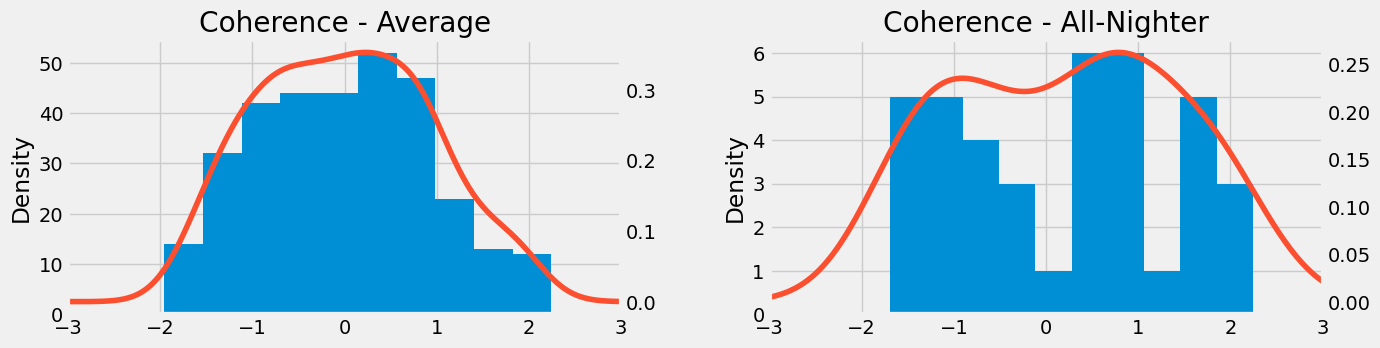

In [21]:
anova_utils.hist_over_groups(aiss, "coh", "Coherence",
                 "preset_label", ["All-Nighter"],
                 size=(15, 5))


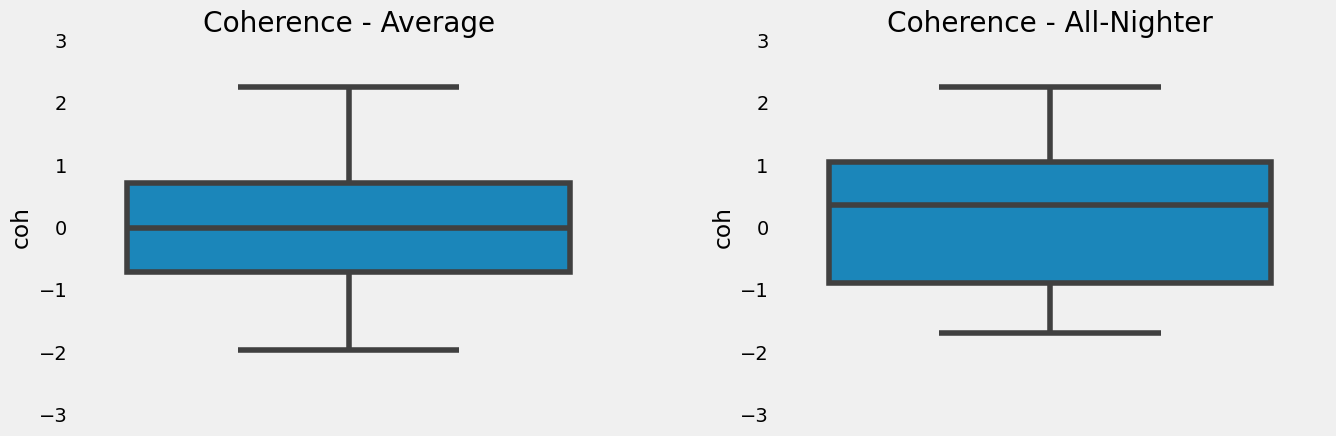

In [22]:
anova_utils.box_over_groups(aiss, "coh", "Coherence",
                "preset_label", ["All-Nighter"],
                size=(15, 6), save_plot="graphs/box_coh.png")


### Pace: High Variance for Low Rider, Low Variance for Morpho

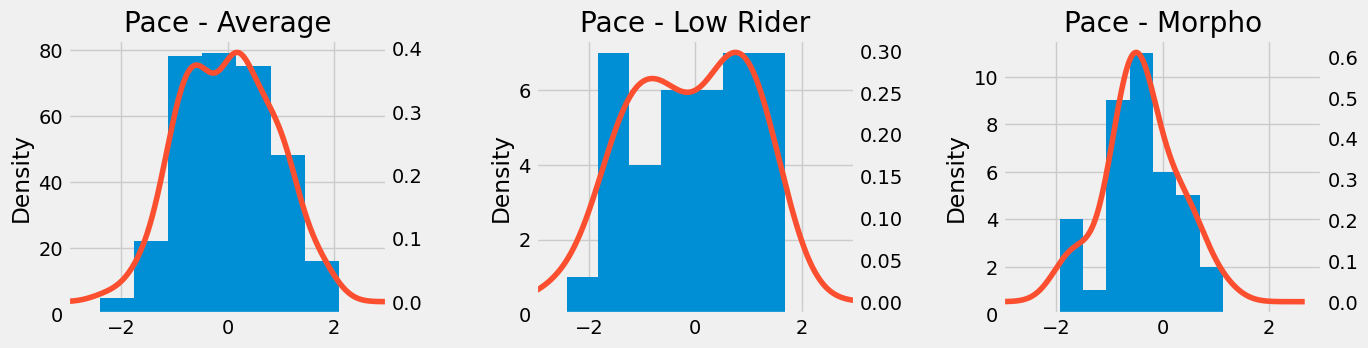

In [23]:
anova_utils.hist_over_groups(aiss, "pace", "Pace",
                 "preset_label", ["Low Rider", "Morpho"],
                 size=(15, 5), bins_n=7)

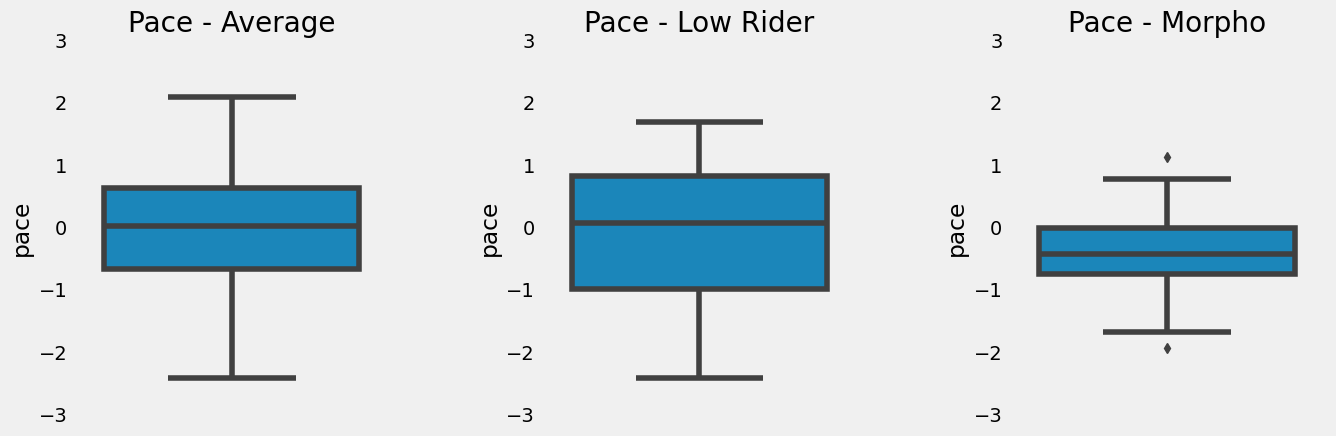

In [24]:
anova_utils.box_over_groups(aiss, "pace", "Pace",
                "preset_label", ["Low Rider", "Morpho"],
                size=(15, 6), save_plot="graphs/box_pac.png")


### Summary Of Preset Effects
The following table was created to give a quick overview of the effects of the presets on the story aspects for the NAI community.

| Preset               | Performance during continuous story generation<br />(Without user intervention)                                                                             |
| :------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Genesis              | Less coherent than the average                                                                                                                              |
| Basic Coherence      | Narrow range in terms of Coherence.<br />Most outputs are close to average Coherence.<br />(= Low variance)                                                 |
| Ouroboros, Low Rider | Solid - average on all story aspects                                                                                                                        |
| Ace of Spade         | Less repetitions than the average                                                                                                                           |
| All-Nighter          | Wide range of possible outputs in terms of Coherence.<br />You'll get more incoherent outputs, but also more strongly coherent ones.<br />(= High Variance) |
| Morpho               | Major issues with repetitions<br />Low pace (possibly due to repetitions)                                                                                   |


# Is Readability A Predictor For Story Factors?

Could we use automatic readability ratings (like the [Flesch Reading Ease Score](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests#Flesch_reading_ease)) to serve as a proxy for story factors? To test this idea, I will test if readability scores have any predictive power for the story factors.

I will be considering the Flesch Reading Ease Score, as well as [textstat's](https://pypi.org/project/textstat/) consensus readability score (a combination of various automatic readability scores).

As a preliminary check, I will look at some scatterplots to see if the relationship between readability and story factors is linear.

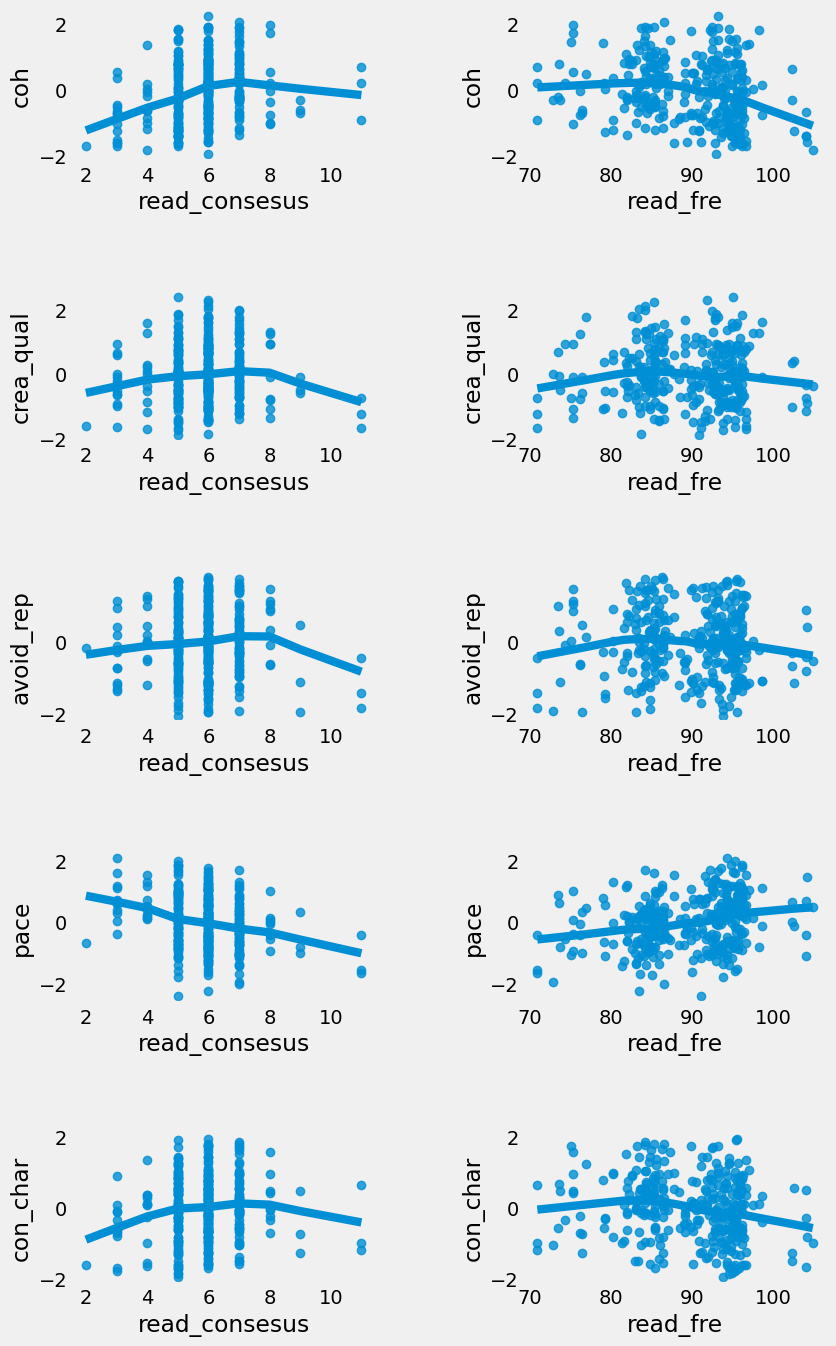

In [25]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))
fig.tight_layout(pad=5.0)
plt.grid(False)

sns.regplot(data=aiss, y="coh",
            x="read_consesus", lowess=True, ax=axes[0, 0])
sns.regplot(data=aiss, y="coh",
            x="read_fre", lowess=True, ax=axes[0, 1])
sns.regplot(data=aiss, y="crea_qual",
            x="read_consesus", lowess=True, ax=axes[1, 0])
sns.regplot(data=aiss, y="crea_qual",
            x="read_fre", lowess=True, ax=axes[1, 1])
sns.regplot(data=aiss, y="avoid_rep",
            x="read_consesus", lowess=True, ax=axes[2, 0])
sns.regplot(data=aiss, y="avoid_rep",
            x="read_fre", lowess=True, ax=axes[2, 1])
sns.regplot(data=aiss, y="pace",
            x="read_consesus", lowess=True, ax=axes[3, 0])
sns.regplot(data=aiss, y="pace",
            x="read_fre", lowess=True, ax=axes[3, 1])
sns.regplot(data=aiss, y="con_char",
            x="read_consesus", lowess=True, ax=axes[4, 0])
sns.regplot(data=aiss, y="con_char",
            x="read_fre", lowess=True, ax=axes[4, 1])
for ax in fig.axes:
    ax.grid(False)

plt.show()


A couple of relationships might be quadratic, so worth running a k-fold cross-validation to see if linear or non-linear models reach any meaningful predictive power.

In [26]:
# Setting up k-fold cross validation

kf = KFold(10, shuffle=True, random_state=42)

# Defining predictors for models
aiss["read_cent"] = aiss["read_consesus"].apply(
    lambda x: x-aiss["read_consesus"].mean())  # centering
aiss["read_fre_cent"] = aiss["read_fre"].apply(
    lambda x: x-aiss["read_fre"].mean())

aiss["read_cent2"] = aiss["read_cent"]*aiss["read_cent"]
aiss["read_cent3"] = aiss["read_cent"]**3
aiss["read_fre_cent2"] = aiss["read_fre_cent"]*aiss["read_fre_cent"]
aiss["read_fre_cent3"] = aiss["read_fre_cent"]**3

lin_model = linreg()

pred_li = [
    ("linear consensus", ["read_cent"]),
    ("quadratic consensus", ["read_cent", "read_cent2"]),
    ("cubic consensus", ["read_cent", "read_cent2", "read_cent3"]),
    ("linear FRE", ["read_fre_cent"]),
    ("quadratic FRE", ["read_fre_cent", "read_fre_cent2"]),
    ("cubic FRE", ["read_fre_cent", "read_fre_cent2", "read_fre_cent3"]),
    ]
outcomes = ["coh", "crea_qual", "avoid_rep",
              "pace", "con_char"]


for outcome in outcomes:
    y = aiss[outcome]

    for pred in pred_li:
        current_preds = pred[1]
        x = aiss.loc[:, current_preds]

        current_model_name = pred[0]

        cross_val = cross_validate(lin_model, x, y,
                                   scoring=["neg_mean_squared_error", "r2"], cv=kf)

        neg_mses = cross_val["test_neg_mean_squared_error"]
        r_squares = cross_val["test_r2"]
        avg_rmse = np.mean((neg_mses*-1)**0.5)
        avg_r_sq = np.mean(r_squares)
        print("Model performance for {} model predicting {}:".format(
            current_model_name, outcome))
        print("r-square: {:.4f}    RMSE: {:.4f}".format(avg_r_sq, avg_rmse))
    print("")


Model performance for linear consensus model predicting coh:
r-square: 0.0305    RMSE: 0.9044
Model performance for quadratic consensus model predicting coh:
r-square: 0.0608    RMSE: 0.8899
Model performance for cubic consensus model predicting coh:
r-square: 0.0503    RMSE: 0.8948
Model performance for linear FRE model predicting coh:
r-square: 0.0241    RMSE: 0.9074
Model performance for quadratic FRE model predicting coh:
r-square: 0.0434    RMSE: 0.8979
Model performance for cubic FRE model predicting coh:
r-square: 0.0386    RMSE: 0.9001

Model performance for linear consensus model predicting crea_qual:
r-square: -0.0476    RMSE: 0.9029
Model performance for quadratic consensus model predicting crea_qual:
r-square: -0.0199    RMSE: 0.8905
Model performance for cubic consensus model predicting crea_qual:
r-square: -0.0233    RMSE: 0.8919
Model performance for linear FRE model predicting crea_qual:
r-square: -0.0474    RMSE: 0.9027
Model performance for quadratic FRE model predict

In general, the predictive performance of readability is far away from what could be considered useful for a proxy measure.

However, for coherence there still seems to be some weak quadratic relationship with readability that might be worth exploring. The consensus readability score seems to be a bit better at predicting coherence than the Flesch Reading Ease Score alone.

For other story factors, the predictive power of readability is negligible to non-existent (_r²s_ < 0.02).

## Regression Diagnostics

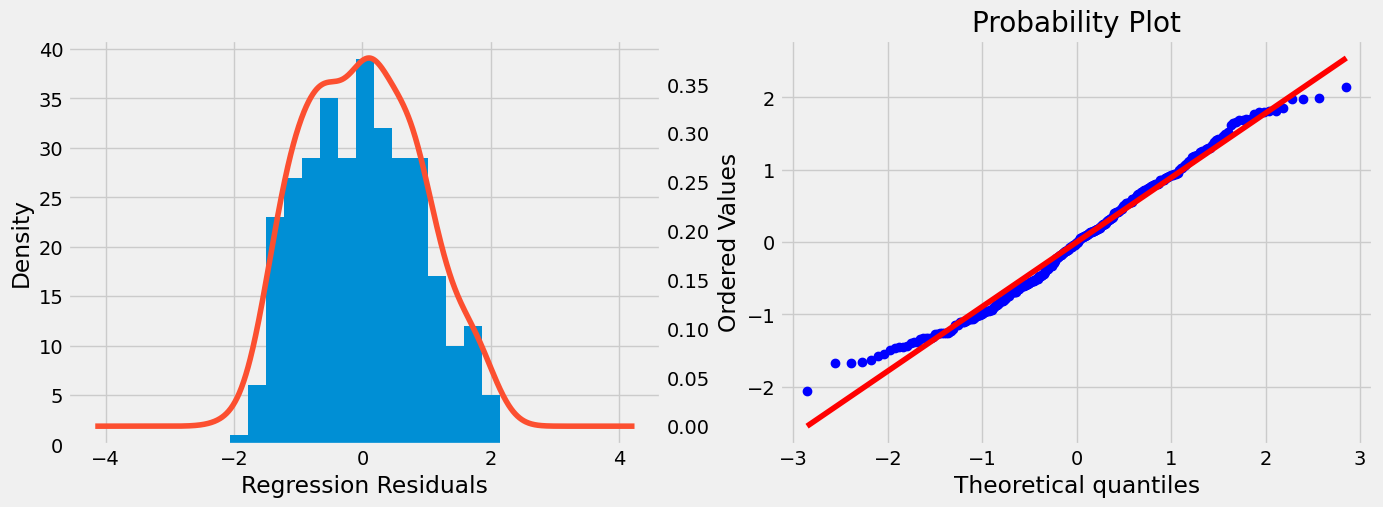

Skewness: 0.1759
Kurtosis: -0.7185


In [27]:
# Fit model and save residuals
lin_model = linreg()
x = aiss[["read_cent", "read_cent2"]]
y = aiss["coh"]
lin_model.fit(x, y)

pred = lin_model.predict(x)
obs_pred_res = pd.DataFrame(
    {'observed': aiss["coh"], 'predicted': pred})
obs_pred_res["residuals"] = \
    obs_pred_res['observed'] - obs_pred_res['predicted']

# Check for normal distribution of residuals with histogram and Q-Q plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograms with KDE
ax1 = obs_pred_res["residuals"].plot.hist(ax=axes[0], bins=15)
ax1.set_xlabel("Regression Residuals")
obs_pred_res["residuals"].plot.kde(ax=axes[0], secondary_y=True)
# Q-Q Plot
stats.probplot(obs_pred_res["residuals"], dist="norm", plot=axes[1])
plt.show()

# Skewness and kurtosis
print("Skewness: {:.4f}".format(stats.skew(obs_pred_res["residuals"])))
print("Kurtosis: {:.4f}".format(stats.kurtosis(obs_pred_res["residuals"])))

The distribution of the residuals looks fairly normal.

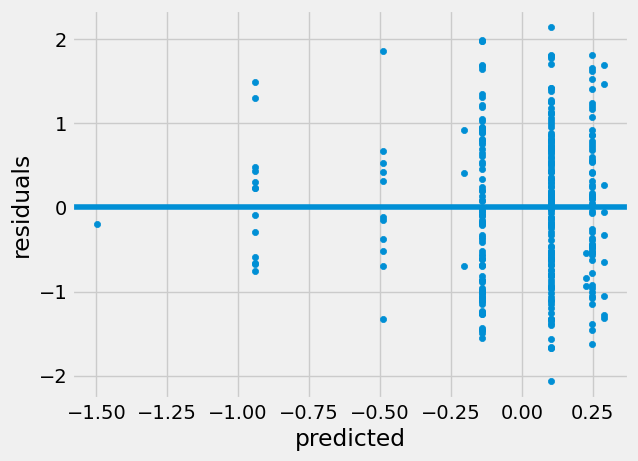

In [28]:
# Checking for Homoscedasticity

plot = obs_pred_res.plot.scatter(x="predicted", y="residuals")
#horiz_line_data = np.array([40 for i in xrange(len(xs))])
plt.axhline(y=0, linestyle='-')
plt.show()

The distribution of the residuals looks a bit heteroscedastic (larger errors for higher predicted values). I will be using HC3 standard errors to account for this.

## Running the Regression

In [29]:
mod_formula = "coh ~ read_cent + read_cent2"

mod_results = smf.ols(mod_formula, data=aiss).fit(cov_type="HC3")

mod_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    coh   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.081
Method:                 Least Squares   F-statistic:                     20.46
Date:                Mon, 05 Dec 2022   Prob (F-statistic):           4.34e-09
Time:                        22:27:12   Log-Likelihood:                -420.79
No. Observations:                 323   AIC:                             847.6
Df Residuals:                     320   BIC:                             858.9
Df Model:                           2                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0720      0.055      1.314      0.189      -0.035       0.179
read_cent      0.2109      0.040      5.303      0.000       0.133       0.289
read_cent2    -0.0513      0.015     -3.521      0.000      -0.080      -0.023
==============================================================================
Omnibus:                       18.107   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.614
Skew:                           0.176   Prob(JB):                       0.0135
Kurtosis:                       2.281   Cond. No.                         3.91
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

### Plotting The Relationship

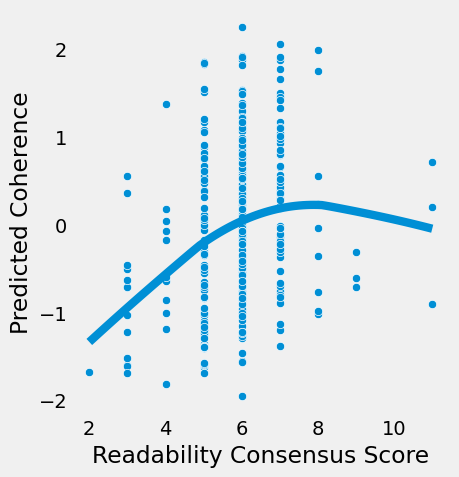

In [30]:
read_min = aiss["read_consesus"].min()
read_max = aiss["read_consesus"].max()
read_plot_vals = np.arange(read_min, read_max+0.1, 0.1)

# Dataframe with values to predict (all in one graph)
pred_df = pd.DataFrame()

pred_df["Readability Consensus Score"] = read_plot_vals
pred_df["read_cent"] = pred_df["Readability Consensus Score"].apply(
    lambda x: x-aiss["read_consesus"].mean())
pred_df["read_cent2"] = pred_df["read_cent"]*pred_df["read_cent"]
pred_df["Predicted Coherence"] = mod_results.predict(pred_df)

# Plotting
read_coh_plot = sns.lmplot(
    x="Readability Consensus Score", y="Predicted Coherence", data=pred_df,
    lowess=True, scatter=False
    )
read_coh_rand_plot = sns.scatterplot(
    data=aiss, x="read_consesus", y="coh"
    )

plt.grid(False)
plt.show()

In [31]:
# maximum predicted readability
print("Maximum predicted coherence:")
print(pred_df.iloc[
    pred_df["Predicted Coherence"].idxmax(),[0,3]
    ].round(2).to_string())

Maximum predicted coherence:
Readability Consensus Score    7.90
Predicted Coherence            0.29
